# Lab 2: Step-by-step fine-tune BERT model on Local Environment

---

## Introduction
---

본 모듈에서는 허깅페이스(HF; Hugging Face) `transformers` 및 `datasets` 라이브러리를 사용하여 한국어 텍스트 감성 분류 파인 튜닝을 수행합니다. 허깅페이스 라이브러리로 모델을 훈련하는 방법은 https://huggingface.co/docs/transformers/training 을 참조하세요. 그리고 트랜스포머와 BERT에 대한 배경 지식이 필요하면 아래 링크도 같이 참조하세요.

- 트랜스포머: https://housekdk.gitbook.io/ml/ml/nlp/transformer
- BERT: https://housekdk.gitbook.io/ml/ml/nlp/bert

_**Note: SageMaker Studio Lab, SageMaker Studio, SageMaker 노트북 인스턴스, 또는 여러분의 로컬 머신에서 이 데모를 실행할 수 있습니다. SageMaker Studio Lab을 사용하는 경우 GPU를 활성화하세요.**_

In [1]:
import os
import torch
import transformers
import numpy as np
from torch.utils.data import DataLoader
from torch.optim import AdamW
from transformers import get_scheduler
from transformers import BertForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from datasets import load_from_disk, load_dataset
#import torch, torch_xla.core.xla_model as xm
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
os.environ['TOKENIZERS_PARALLELISM'] = "True"
        
# compute metrics function for binary classification
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f|1": f1, "precision": precision, "recall": recall}

<br>

## 1. Dataset preparation and preprocessing
---

### Dataset

본 핸즈온에서 사용할 말뭉치 데이터셋은 네이버 영화 리뷰 감성 분류 데이터(https://github.com/e9t/nsmc/) 공개 데이터셋으로 15만 건의 훈련 데이터와 5만 건의 테스트 데이터로 구성되어 있습니다. 이 데이터셋은 한국어 자연어 처리 모델 벤치마킹에 자주 사용됩니다.

본 모듈은 빠른 실습을 위해 200건의 데이터만 샘플링하여 훈련을 수행합니다.

In [2]:
train_dir = 'train'
eval_dir = 'eval'

def tokenize(batch):
    return tokenizer(batch['document'], padding='max_length', max_length=128, truncation=True)

MODEL_NAME = "bert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)#.to(device)

if (os.path.exists(train_dir) and os.path.exists(train_dir)):
    print('== Load dataset from disk')
    train_dataset = load_from_disk(train_dir)
    eval_dataset = load_from_disk(eval_dir)
else:
    print('== Preprocessing dataset from scratch')
    train_dataset = load_dataset("nsmc", split="train")
    eval_dataset = load_dataset("nsmc", split="test")

    train_num_samples = 200
    eval_num_samples = 100
    train_dataset = train_dataset.shuffle(seed=42).select(range(train_num_samples))
    eval_dataset = eval_dataset.shuffle(seed=42).select(range(eval_num_samples))

    # tokenize dataset
    train_dataset = train_dataset.map(tokenize, batched=True, remove_columns=['id', 'document'])
    eval_dataset = eval_dataset.map(tokenize, batched=True, remove_columns=['id', 'document'])

    # set format for pytorch
    train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
    eval_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

    train_dataset = train_dataset.rename_column("label", "labels")
    eval_dataset = eval_dataset.rename_column("label", "labels")

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

== Load dataset from disk


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/datasets/arrow_dataset.py:1533: FutureWarning: 'fs' was is deprecated in favor of 'storage_options' in version 2.8.0 and will be removed in 3.0.0.
You can remove this warning by passing 'storage_options=fs.storage_options' instead.
  warnings.warn(


<br>

## 2. Training and Evaluation
---

### Option 1. Fine-tune with HF Transformers Trainer

허깅페이스 라이브러리의 `Trainer`로 모델을 쉽고 빠르게 훈련할 수 있습니다. 이 API를 사용하면 분산 훈련에 대한 추가 코딩 없이 편리하게 분산 훈련이 가능합니다.

In [3]:
training_args = TrainingArguments(
    num_train_epochs=3,
    learning_rate=3e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    metric_for_best_model="accuracy",
    output_dir="./results",
)

trainer = Trainer(
    model= model,
    args=training_args,
    train_dataset=train_dataset.with_format("torch"),
    eval_dataset=eval_dataset.with_format("torch"),
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

train_result = trainer.train()
print(train_result)

eval_result = trainer.evaluate()
print(eval_result)

/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 200
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 256
  Gradient Accumulation steps = 1
  Total optimization steps = 3
  Number of trainable parameters = 177854978
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather alo

Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 100
  Batch size = 256


TrainOutput(global_step=3, training_loss=0.6933660507202148, metrics={'train_runtime': 34.1515, 'train_samples_per_second': 17.569, 'train_steps_per_second': 0.088, 'total_flos': 39466658304000.0, 'train_loss': 0.6933660507202148, 'epoch': 3.0})


{'eval_loss': 0.6877052187919617, 'eval_accuracy': 0.5, 'eval_f|1': 0.038461538461538464, 'eval_precision': 0.25, 'eval_recall': 0.020833333333333332, 'eval_runtime': 0.6517, 'eval_samples_per_second': 153.438, 'eval_steps_per_second': 1.534, 'epoch': 3.0}


### Option 2. Fine-tune in PyTorch (from scratch)

자체 훈련 코드 작성을 선호하거나 추가 로직이 필요한 경우, 기존 PyTorch의 방식대로 훈련 코드를 작성합니다.

In [4]:
del trainer
torch.cuda.empty_cache()

훈련 및 검증 데이터의 미니배치 순회를 위한 DataLoader를 생성합니다.

In [5]:
train_dataloader = DataLoader(train_dataset, batch_size=32, num_workers=4, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=32, num_workers=4)

에포크와 DataLoader를 순회하면서 훈련을 수행합니다. 자세한 내용은 https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html 를 참조하세요.

In [6]:
optimizer = AdamW(model.parameters(), lr=3e-5)
num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

from tqdm import tqdm, trange
progress_bar = tqdm(range(num_training_steps))

model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        print(loss)
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

  5%|▍         | 1/21 [00:01<00:27,  1.37s/it]

tensor(0.6833, device='cuda:0', grad_fn=<NllLossBackward0>)


 10%|▉         | 2/21 [00:01<00:12,  1.47it/s]

tensor(0.6422, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.6681, device='cuda:0', grad_fn=<NllLossBackward0>)


 19%|█▉        | 4/21 [00:01<00:06,  2.81it/s]

tensor(0.6595, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.6689, device='cuda:0', grad_fn=<NllLossBackward0>)


 29%|██▊       | 6/21 [00:02<00:03,  3.79it/s]

tensor(0.7232, device='cuda:0', grad_fn=<NllLossBackward0>)


 33%|███▎      | 7/21 [00:02<00:05,  2.61it/s]

tensor(0.7452, device='cuda:0', grad_fn=<NllLossBackward0>)


 38%|███▊      | 8/21 [00:03<00:05,  2.36it/s]

tensor(0.5642, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.6080, device='cuda:0', grad_fn=<NllLossBackward0>)


 48%|████▊     | 10/21 [00:03<00:03,  3.27it/s]

tensor(0.6101, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.5590, device='cuda:0', grad_fn=<NllLossBackward0>)


 57%|█████▋    | 12/21 [00:04<00:02,  4.01it/s]

tensor(0.5509, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.5421, device='cuda:0', grad_fn=<NllLossBackward0>)


 62%|██████▏   | 13/21 [00:04<00:01,  4.29it/s]

tensor(0.4571, device='cuda:0', grad_fn=<NllLossBackward0>)


 71%|███████▏  | 15/21 [00:05<00:01,  3.54it/s]

tensor(0.4887, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.5081, device='cuda:0', grad_fn=<NllLossBackward0>)


 81%|████████  | 17/21 [00:05<00:00,  4.09it/s]

tensor(0.4557, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.5215, device='cuda:0', grad_fn=<NllLossBackward0>)


 90%|█████████ | 19/21 [00:05<00:00,  4.51it/s]

tensor(0.4902, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.4428, device='cuda:0', grad_fn=<NllLossBackward0>)


 95%|█████████▌| 20/21 [00:06<00:00,  4.66it/s]

tensor(0.4526, device='cuda:0', grad_fn=<NllLossBackward0>)


`add_batch`를 사용하여 모든 배치를 누적하고 마지막에 지표를 계산합니다. 허깅페이스의 `evaluate` 라이브러리를 활용하면 추가 코딩 없이 편리하게 널리 활용되는 지표들이 사용 가능합니다. 

In [7]:
import evaluate

preds_batch = torch.empty([0]).to(device)
truths_batch = torch.empty([0]).to(device)
metrics = evaluate.combine(["accuracy", "f1", "precision", "recall"])
model.eval()
for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    preds = torch.argmax(logits, dim=-1)
    preds_batch = torch.cat([preds_batch, preds], dim=0)
    truths_batch = torch.cat([truths_batch, batch['labels']], dim=0)
    metrics.add_batch(predictions=preds, references=batch["labels"])

metrics.compute()

{'accuracy': 0.65,
 'f1': 0.6464646464646465,
 'precision': 0.6274509803921569,
 'recall': 0.6666666666666666}

<br>

## 3. Visualization
---


In [8]:
def plot_confusion_matrix(cm, target_names=None, cmap=None, normalize=True, labels=True, title='Confusion matrix'):
    import itertools
    import matplotlib.pyplot as plt
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)
    
    if labels:
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            if normalize:
                plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")
            else:
                plt.text(j, i, "{:,}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [9]:
## If you want to use HF Library
# eval_results = trainer.predict(eval_dataset)
# y_true = eval_results.label_ids
# y_pred = np.argmax(eval_results.predictions, axis=1)

y_true = truths_batch.cpu().numpy()
y_pred = preds_batch.cpu().numpy()

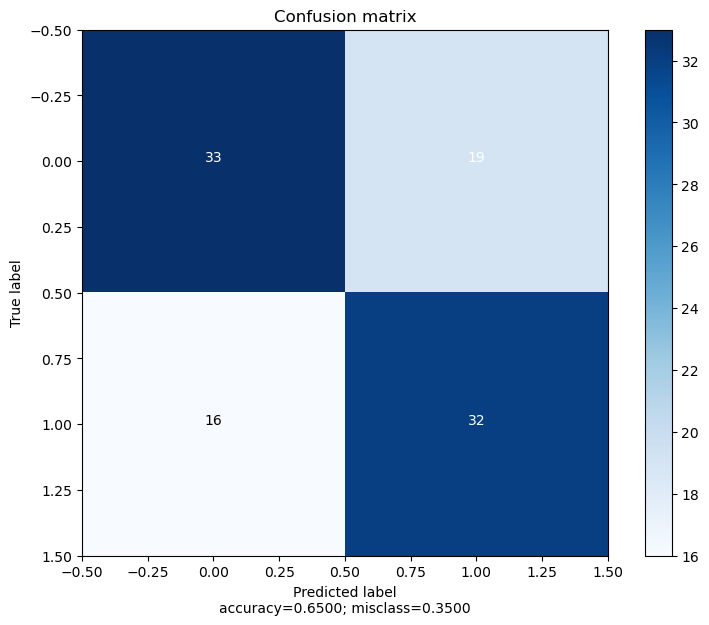

100%|██████████| 21/21 [1:01:47<00:00, 176.55s/it]

In [10]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cf, normalize=False)